In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.lines as mlines
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Circle
from scanpro import scanpro, anova
from scanpro.get_transformed_props import get_transformed_props
import scipy.sparse
from sklearn.preprocessing import MinMaxScaler

sc._settings.ScanpyConfig(n_jobs=-1)

In [2]:
# Path to font
helvetica_neue_path = Path.home() / ".local/share/fonts/HelveticaNeue-Regular.ttf"

# Create a FontProperties object
prop_neue = fm.FontProperties(fname=helvetica_neue_path)
helvetica_neue_name = prop_neue.get_name()

# Custom font/graphing for Seaborn
custom_context = {
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 7,
    'axes.linewidth': 0.6,
    'grid.linewidth': 0.6,
    'lines.linewidth': 0.6,
    'lines.markersize': 3,
    'patch.linewidth': 0.6,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.title_fontsize': 7,
}

# Additional custom aesthetics for Seaborn
custom_style = {
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.color': '#EAEAEA',
    'grid.linestyle': '--',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'ytick.left': True,
    'xtick.bottom': True,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False
}

# Use set_theme and pass rc with font settings
sns.set_theme(
    context=custom_context,
    style=custom_style,
    rc={
        'font.family': 'sans-serif',
        'font.sans-serif': [helvetica_neue_name],
        'font.size': 7,
        'axes.labelsize': 7,
        'axes.titlesize': 7,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7
    }
)

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# Set root and output directory
REPO_ROOT = Path.cwd().resolve()
output_dir = REPO_ROOT / "figure4_outputs"
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Import anndata object
adata_path = (REPO_ROOT / "GSE290679_10069-MS_allsamples_processed_labeled_filtered.h5ad").resolve()

if not adata_path.exists():
    raise FileNotFoundError(
        f"AnnData file not found at:\n{adata_path}\n\n"
        "Download the file from GEO (GSE290679) and place it in the repository root."
    )

adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 644147 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.ribosomal', 'percent.heme', 'percent.mt', 'percent_mito_filtered', 'percent_feature_filtered', 'percent_doublets', 'SCARAB_ID', 'Batch', 'Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'highlight', 'leiden-sub', 'celltype_coarse', 'celltype_fine', 'umap_x', 'umap_y', 'group_density'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Batch_colors', 'Biologic_Sex_colors', 'Group_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_coarse_colors', 'celltype_fine_colors', 'group_density_params', 'highlight_colors', 'hvg', 'leiden', 'leiden-sub_colors', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scVI_normalized'
    ob

In [5]:
# Define custom colors for UMAP
custom_colors = {
    'CD14 Mono': '#A3A8E2',        # Lavender Blue
    'CD16 Mono': '#4D90A7',        # Darker Blue
    'cDC1': '#AB47BC',             # Purple
    'cDC2': '#F48FB1',             # Light Coral Pink
    'pDC': '#EF5350',              # Red Orange
    'AXL+ DC': '#66BB6A',          # Grass Green
    'HSPC': '#AED581',             # Yellow Green
    'Platelet/MK': '#9C9F76',      # Subdued Yellow Green
    'B Naive': '#FFD54F',          # Mustard Yellow
    'B Transitional': '#FFB74D',   # Mellow Apricot
    'B Memory': '#FF8A65',         # Pale Red
    'Plasmablast': '#B24D4D',      # Dark Red
    'CD4 T Naive': '#A1887F',      # Pale Brown
    'CD4 T Eff/EM': '#BBD5E2',     # Blue Grey
    'CD4 T CM': '#9575CD',         # Soft Purple
    'CD4 Treg': '#BA68C8',         # Light Purple
    'CD8 T Naive': '#7986CB',      # Lavender Blue
    'DN T': '#64B5F6',             # Light Blue
    'MAIT': '#4FC3F7',             # Vivid Sky Blue
    'Prolif Lymph': '#6DAF7B',     # Greeny Yellow
    'CD4 CTL': '#AED581',          # Yellow Green
    'CD8 T Eff/EM': '#FFEE58',     # Yellow
    'CD8 T CM': '#98A456',         # Olive Green
    'γδ T': '#FFCA28',             # Amber
    'NK': '#FFAB91',               # Salmon
    'NK CD56 Bright': '#BCAAA4',   # Taupe
    'ILC': '#0E0908'               # Dark Brown
}

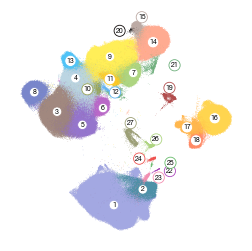

1 = CD14 Mono
2 = CD16 Mono
3 = CD4 T Naive
4 = CD4 T Eff/EM
5 = CD4 T CM
6 = CD4 Treg
7 = CD4 CTL
8 = CD8 T Naive
9 = CD8 T Eff/EM
10 = CD8 T CM
11 = γδ T
12 = DN T
13 = MAIT
14 = NK
15 = NK CD56 Bright
16 = B Naive
17 = B Transitional
18 = B Memory
19 = Plasmablast
20 = ILC
21 = Prolif Lymph
22 = cDC1
23 = cDC2
24 = pDC
25 = AXL+ DC
26 = HSPC
27 = Platelet/MK


In [6]:
# Extract UMAP coordinates
umap_coords = adata.obsm['X_umap']

# Set numbering order
celltype_order = [
    'CD14 Mono', 'CD16 Mono', 'CD4 T Naive', 'CD4 T Eff/EM', 'CD4 T CM',
    'CD4 Treg', 'CD4 CTL', 'CD8 T Naive', 'CD8 T Eff/EM', 'CD8 T CM',
    'γδ T', 'DN T', 'MAIT', 'NK', 'NK CD56 Bright', 'B Naive',
    'B Transitional', 'B Memory', 'Plasmablast', 'ILC', 'Prolif Lymph',
    'cDC1', 'cDC2', 'pDC', 'AXL+ DC', 'HSPC', 'Platelet/MK'
]

# Plot UMAP
fig, ax = plt.subplots(figsize=(3, 3))
sc.pl.umap(
    adata,
    color='celltype_fine',
    palette=custom_colors,
    frameon=False,
    size=0.5,
    show=False,
    legend_loc='none',
    ax=ax
)

# Rasterize UMAP for export
ax.set_rasterization_zorder(2)

# Map each cell type to its cluster number
celltype_to_num = {ct: i + 1 for i, ct in enumerate(celltype_order)}

# Add labels at centroid + manual adjustments and correct z-order
for cell_type in celltype_order:
    if cell_type not in adata.obs['celltype_fine'].unique():
        continue

    cell_indices = adata.obs['celltype_fine'] == cell_type
    cell_coords = umap_coords[cell_indices, :]
    centroid = np.mean(cell_coords, axis=0)

    if cell_type == 'ILC':
        new_x, new_y = centroid[0] + (-1.3), centroid[1] + 0
    elif cell_type == 'Prolif Lymph':
        new_x, new_y = centroid[0] + (4.7), centroid[1] + (1.6)
    elif cell_type == 'CD8 T CM':
        new_x, new_y = centroid[0] + (-0.9), centroid[1] + 0
    elif cell_type == 'CD4 T Eff/EM':
        new_x, new_y = centroid[0] + (-0.5), centroid[1] + 1.1
    elif cell_type == 'CD8 T Eff/EM':
        new_x, new_y = centroid[0] + 0, centroid[1] + 0.3
    elif cell_type == 'Plasmablast':
        new_x, new_y = centroid[0] + 0, centroid[1] + 1.1
    elif cell_type == 'Platelet/MK':
        new_x, new_y = centroid[0] + 0, centroid[1] + 1.5
    elif cell_type == 'HSPC':
        new_x, new_y = centroid[0] + 0.7, centroid[1] + 0.7
    elif cell_type == 'pDC':
        new_x, new_y = centroid[0] + (-1.5), centroid[1] + 0
    elif cell_type == 'AXL+ DC':
        new_x, new_y = centroid[0] + 2.1, centroid[1] + 0.25
    elif cell_type == 'cDC1':
        new_x, new_y = centroid[0] + 1.45, centroid[1] + (-0.1)
    elif cell_type == 'cDC2':
        new_x, new_y = centroid[0] + 1.7, centroid[1] + 0.55
    elif cell_type == 'B Transitional':
        new_x, new_y = centroid[0] + (-0.5), centroid[1] + 0
    elif cell_type == 'B Naive':
        new_x, new_y = centroid[0] + 0, centroid[1] + 0.1
    elif cell_type == 'NK CD56 Bright':
        new_x, new_y = centroid[0] + 0.5, centroid[1] + 1.3
    elif cell_type == 'CD4 CTL':
        new_x, new_y = centroid[0] + 0.4, centroid[1] + 0.2
    elif cell_type == 'γδ T':
        new_x, new_y = centroid[0] + 0.05, centroid[1] + (-0.15)
    elif cell_type == 'CD14 Mono':
        new_x, new_y = centroid[0] + 0.2, centroid[1] + (-0.4)
    elif cell_type == 'CD16 Mono':
        new_x, new_y = centroid[0] + 0, centroid[1] + (-0.1)
    elif cell_type == 'CD4 T CM':
        new_x, new_y = centroid[0] + 0.4, centroid[1] + (-0.6)
    elif cell_type == 'CD4 T Naive':
        new_x, new_y = centroid[0] + (-0.2), centroid[1] + (-0.1)
    elif cell_type == 'CD4 Treg':
        new_x, new_y = centroid[0] + 0.6, centroid[1] + (-0.3)
    elif cell_type == 'DN T':
        new_x, new_y = centroid[0] + 1, centroid[1] + (-0.35)
    else:
        new_x, new_y = centroid[0], centroid[1]

    num_str = str(celltype_to_num[cell_type])

    ax.text(
        new_x, new_y, num_str,
        ha='center', va='center',
        fontsize=5,
        color='black',
        bbox=dict(
            boxstyle='circle,pad=0.25',
            fc='white',
            ec=custom_colors[cell_type],
            lw=0.6
        ),
        zorder=10
    )

ax.set_title('')

plt.savefig(output_dir / 'UMAP-numbered_rasterUMAP.svg', format='svg', dpi=1200, pad_inches=0)

plt.show()

for i, ct in enumerate(celltype_order, start=1):
    print(f"{i} = {ct}")

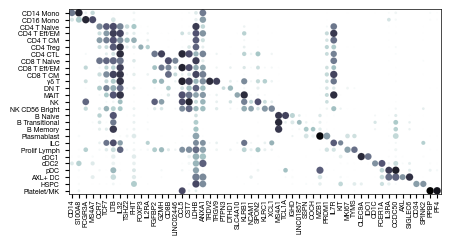

In [7]:
# List of marker genes
marker_genes = [
    'CD14', 'S100A8',
    'FCGR3A', 'MS4A7',
    'CCR7', 'TCF7',
    'LTB', 'IL32',
    'TSHZ2', 'FHIT',
    'FOXP3', 'IL2RA',
    'FGFBP2', 'GZMH',
    'CD8B', 'LINC02446',
    'CCL5', 'CST7',
    'LDHB', 'ANXA1',
    'TRDV2', 'TRGV9',
    'PTPN3', 'DTHD1',
    'SLC4A10', 'KLRB1',
    'NCAM1', 'SPON2',
    'KLRC1', 'XCL1',
    'MS4A1', 'TCL1A',
    'IGHD', 'LINC01857',
    'SSPN', 'COCH',
    'MZB1', 'PRDM1',
    'IL7R', 'KIT',
    'MKI67', 'TYMS',
    'CLEC9A', 'IDO1',
    'CD1C', 'FCER1A',
    'IL3RA', 'CCDC50',
    'AXL', 'SIGLEC6',
    'CD34', 'SPINK2',
    'PPBP', 'PF4'
]

# Extract log-normalized counts (stored in .raw)
adata_exp = adata.raw.to_adata()

# Subset for marker genes
adata_subset = adata_exp[:, marker_genes]

# Scale data
scaler = MinMaxScaler()
adata_scaled = adata_subset.X.toarray() if scipy.sparse.issparse(adata_subset.X) else adata_subset.X
adata_scaled = scaler.fit_transform(adata_scaled)

# Extract cell type labels
cell_types = adata.obs['celltype_fine'].values

# Calculate expression values (mean/%)
plot_data = []
for cell_type in np.unique(cell_types):
    indices = np.where(cell_types == cell_type)[0]
    scaled_subset = adata_scaled[indices]
    for gene_idx, gene in enumerate(marker_genes):
        mean_expression = np.mean(scaled_subset[:, gene_idx])
        percent_cells = np.sum(scaled_subset[:, gene_idx] > 0) / len(scaled_subset) * 100
        plot_data.append((cell_type, gene, mean_expression, percent_cells))

# Create a DF for plotting
plot_df = pd.DataFrame(plot_data, columns=['celltype', 'genes', 'mean_expression', 'percent_cells'])

# Convert 'celltype' and 'genes' to categorical for correct plotting order
plot_df['celltype'] = pd.Categorical(plot_df['celltype'], categories=celltype_order, ordered=True)
plot_df['genes'] = pd.Categorical(plot_df['genes'], categories=marker_genes, ordered=True)

# Generate dot plot
fig, ax = plt.subplots(figsize=(4.8, 2.4))
sns.scatterplot(
    data=plot_df, x='genes', y='celltype', size='percent_cells', 
    hue='mean_expression', palette='bone_r', legend=None, sizes=(0.5, 30), ax=ax
)

ax.set_xticks(np.arange(len(marker_genes)))
ax.set_xticklabels([])

for i, label in enumerate(marker_genes):
    ax.text(i, len(celltype_order) + 0.2, label, rotation=90, fontsize=5, ha='center', va='top')

ax.set_yticks(np.arange(len(celltype_order)))
ax.set_yticklabels(celltype_order, fontsize=5)

ax.set_xlim(-0.5, len(marker_genes) - 0.5)
ax.set_ylim(-0.5, len(celltype_order) - 0.5)

ax.set_xlabel('')
ax.set_ylabel('')

ax.invert_yaxis()

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

for spine in ax.spines.values():
    spine.set_linewidth(0.5)

plt.savefig(output_dir / 'celltype_fine_markers_dotplot.svg', format='svg')
plt.show()

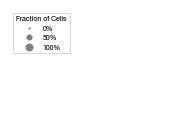

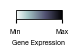

In [8]:
# Set up figure legends for dotplot
fig, ax = plt.subplots(figsize=(2, 1.5))
ax.axis('off')

size_values = [0.5, 15.25, 30]
size_labels = ['0%', '50%', '100%']

legend_handles = []
scaling_factor = 0.85
for size, label in zip(size_values, size_labels):
    markersize = np.sqrt(size) * scaling_factor
    line = mlines.Line2D([], [], color='gray', marker='o', markersize=markersize, label=label, linestyle='None')
    legend_handles.append(line)

legend1 = ax.legend(handles=legend_handles, title='Fraction of Cells', 
                    loc='upper left', frameon=True, handletextpad=1, fontsize=5, title_fontsize=5)
ax.add_artist(legend1)

fig2, ax2 = plt.subplots(figsize=(0.6, 0.125))
cmap = plt.cm.bone_r
norm = Normalize(vmin=0, vmax=1)

cbar = ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Min', 'Max'])
cbar.set_label('Gene Expression', fontsize=5)

cbar.ax.tick_params(labelsize=5)
cbar.ax.xaxis.label.set_size(5)

fig.savefig(output_dir / 'legend_dot_size.svg', format='svg')
fig2.savefig(output_dir / 'legend_color_bar.svg', format='svg')

plt.show(fig)
plt.show(fig2)

In [9]:
# Coarse cell type proportionality analysis
np.random.seed(42)
out = scanpro(adata, clusters_col='celltype_coarse', samples_col='orig.ident', conds_col='Group', transform='logit')

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


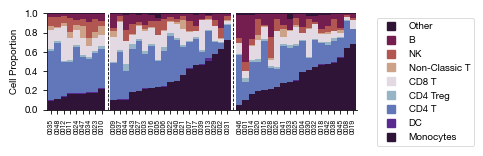

In [10]:
# Extract orig.ident and Group and merge with proportionality results
sample_groups = adata.obs[['orig.ident', 'Group']].drop_duplicates()

props_df = out.props.reset_index()
merged_df = pd.merge(props_df, sample_groups, on='orig.ident')

# Plot proportions per sample by Group
group_order = ['NHC', 'CI-NS', 'CI-Sep']
merged_df['Group'] = pd.Categorical(merged_df['Group'], categories=group_order, ordered=True)

merged_df['Mono_rank'] = merged_df.groupby('Group')['Monocytes'].rank(method='first')
merged_df.sort_values(['Group', 'Mono_rank'], inplace=True)

cell_types = ['Monocytes', 'DC', 'CD4 T', 'CD4 Treg', 'CD8 T', 'Non-Classic T', 'NK', 'B', 'Other']
values = merged_df[cell_types].values.T

cmap = cm.get_cmap('twilight_shifted', len(cell_types))
celltype_colors = {cell_type: cmap(i) for i, cell_type in enumerate(cell_types)}

grouped_samples = [merged_df[merged_df['Group'] == group]['orig.ident'] for group in group_order]
grouped_values = [merged_df[merged_df['Group'] == group][cell_types].values.T for group in group_order]

intra_group_space = -0.2
inter_group_space = 1.5

x_positions = []
x_offset = 0

for group_samples in grouped_samples:
    n_samples = len(group_samples)
    group_positions = np.arange(n_samples) * (1 + intra_group_space) + x_offset
    x_positions.extend(group_positions)
    x_offset = group_positions[-1] + inter_group_space  # Add space for the next group

fig, ax = plt.subplots(figsize=(4, 1.25))

bottom = np.zeros(len(x_positions))
for i, cell_type in enumerate(cell_types):
    ax.bar(x_positions, np.hstack([group for group in grouped_values])[i], bottom=bottom, 
           color=celltype_colors.get(cell_type, '#7F7F7F'), label=cell_type)
    bottom += np.hstack([group for group in grouped_values])[i]

all_sample_ids = np.hstack([group for group in grouped_samples])
short_sample_ids = [sid.split('-')[-1] for sid in all_sample_ids]  # Only keep the last two digits
ax.set_xticks(x_positions)
ax.set_xticklabels(short_sample_ids, rotation=90, fontsize=5)  # Set x-tick label font size to 5

dashed_line_positions = [
    (x_positions[len(grouped_samples[0]) - 1] + x_positions[len(grouped_samples[0])]) / 2,
    (x_positions[len(grouped_samples[0]) + len(grouped_samples[1]) - 1] + x_positions[len(grouped_samples[0]) + len(grouped_samples[1])]) / 2
]

for pos in dashed_line_positions:
    ax.axvline(pos, color='black', linestyle='--', linewidth=0.6, zorder=0)  # Set line width to 0.6

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.2))  # Set y-ticks at specified intervals

ax.set_xlim(x_positions[0] - 0.5, x_positions[-1] + 0.5)

ax.tick_params(width=0.6)

ax.set_ylabel('Cell Proportion')

legend_handles = [
    mlines.Line2D([], [], color=celltype_colors[cell_type], marker='s', linestyle='None', markersize=6)
    for cell_type in reversed(cell_types)  # Invert to match the graph order
]

ax.legend(legend_handles, reversed(cell_types), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)

plt.savefig(output_dir / 'proportions_coarse.svg', format='svg')
plt.show()

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_CI-NS,mean_props_CI-Sep,mean_props_NHC,f_statistics,p_values,adjusted_p_values
clusters,,,,,,,
AXL+ DC,0.000106,0.000109,0.000009,0.000219,21.189884,1.919858e-07,2.591809e-06
B Memory,0.007279,0.007304,0.005692,0.008276,1.413348,2.525949e-01,2.965245e-01
B Naive,0.059806,0.048938,0.097233,0.028501,2.585231,8.512145e-02,1.436424e-01
B Transitional,0.014233,0.012415,0.017769,0.013092,2.167979,1.247262e-01,1.772425e-01
CD4 CTL,0.031924,0.042594,0.010563,0.044539,0.955179,3.914452e-01,4.227608e-01
CD4 T CM,0.076731,0.070669,0.123405,0.026087,10.666320,1.328637e-04,7.174641e-04
CD4 T Eff/EM,0.111096,0.118251,0.079606,0.119777,2.608582,8.333470e-02,1.436424e-01
CD4 T Naive,0.124973,0.087212,0.067210,0.230471,13.540936,1.876807e-05,1.266845e-04
CD4 Treg,0.021643,0.023014,0.019485,0.021614,0.371287,6.916751e-01,6.916751e-01


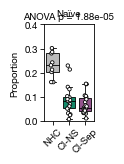

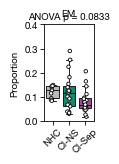

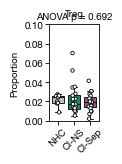

In [11]:
# Fine cell type proportionality analysis

# celltype_fine to visualize
celltypes_of_interest = ["CD4 T Naive", "CD4 T Eff/EM", "CD4 Treg"]

# Group order and palette
group_order   = ['NHC', 'CI-NS', 'CI-Sep']
group_palette = {'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'}

pretty_titles = {
    "CD4 T Naive": "Naïve",
    "CD4 T Eff/EM": "EM",
    "CD4 Treg": "Treg",
}

# Proportionality analysis celltype_fine
out = scanpro(
    adata,
    clusters_col='celltype_fine',
    samples_col='orig.ident',
    conds_col='Group',
    transform='logit',
    conditions=group_order
)

display(out.results)

# Extract proportionality results
props_df = out.props.copy()
sample_col_name = props_df.index.name

props_long = (
    props_df.reset_index()
            .melt(id_vars=[sample_col_name], var_name='celltype_fine', value_name='prop')
)

# Attach Group assignment to proportionality results
sample_groups = (
    adata.obs[['orig.ident', 'Group']]
        .drop_duplicates()
        .rename(columns={'orig.ident': sample_col_name})
)
props_long = props_long.merge(sample_groups, on=sample_col_name, how='left')
props_long = props_long[props_long['Group'].isin(group_order)].copy()
props_long['Group'] = pd.Categorical(props_long['Group'], categories=group_order, ordered=True)

# Plot for celltype_fine of interest
y_axis_limits = {
    "CD4 T Naive": (0, 0.4),
    "CD4 T Eff/EM": (0, 0.4),
    "CD4 Treg": (0, 0.1),
}

for ct in celltypes_of_interest:
    dfg = props_long[props_long['celltype_fine'] == ct].copy()

    props_long[props_long['celltype_fine'].isin(celltypes_of_interest)] \
    .to_csv("scanpro_props_three_CD4_clusters.csv", index=False)

    p_anova = None
    try:
        if ct in out.results.index and 'p_values' in out.results.columns:
            p_anova = out.results.loc[ct, 'p_values']
    except Exception:
        p_anova = None

    fig, ax = plt.subplots(figsize=(0.65, 1.25))

    sns.boxplot(
        data=dfg, x='Group', y='prop',
        order=group_order, palette=group_palette,
        showfliers=False,
        boxprops={'edgecolor': 'black', 'linewidth': 0.6},
        whiskerprops={'color': 'black', 'linewidth': 0.6},
        capprops={'color': 'black', 'linewidth': 0.6},
        medianprops={'color': 'black', 'linewidth': 0.6},
        width=0.75, ax=ax
    )

    sns.stripplot(
        data=dfg, x='Group', y='prop',
        order=group_order, jitter=True, marker='o', size=2.5,
        color='white', edgecolor='black', linewidth=0.6, zorder=3, ax=ax
    )

    y_min, y_max = y_axis_limits.get(ct, (0, 1.0))
    ax.set_ylim(y_min, y_max)

    if ct == "CD4 Treg":
        ax.set_yticks(np.arange(y_min, y_max + 0.001, 0.02))
    else:
        ax.set_yticks(np.linspace(y_min, y_max, 5))

    ax.set_xticks(np.arange(len(group_order)))
    ax.set_xticklabels(group_order, rotation=45, ha='center')
    ax.set_xlabel('')
    ax.set_ylabel('Proportion')
    ax.tick_params(axis='y', direction='out', length=3, width=0.6, pad=1)
    ax.tick_params(axis='x', direction='out', length=3, width=0.6, pad=1)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.6)
        spine.set_color("black")

    ax.set_title(pretty_titles.get(ct, ct))
    if p_anova is not None and np.isfinite(p_anova):
        ax.text(0.5, 1.03, f"ANOVA p = {p_anova:.3g}", ha='center', va='bottom', transform=ax.transAxes)

    ax.set_xlim(-0.55, len(group_order) - 0.45)

    save_name = f"{ct.replace(' ', '_').replace('/', '_')}.svg"
    plt.savefig(output_dir / save_name, format='svg')
    plt.show()